In [55]:
import numpy as np
from lattice_class import *
from hamiltonian_constructor_class import *
import scipy.linalg
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 150

[140, 125, 110, 95]


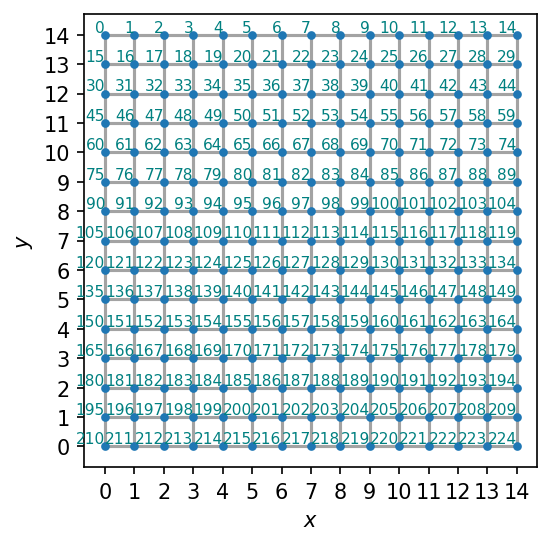

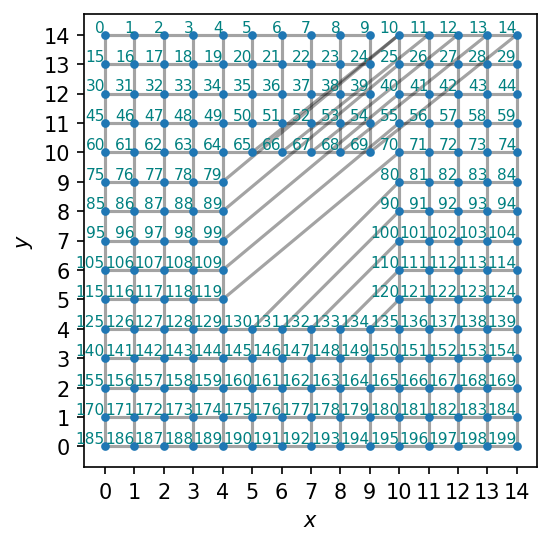

In [56]:
N_hole = 5
N = 3 * N_hole
lattice = SquareLattice(N, BC="open")
middle_sites = [
    (N - N_hole) // 2 * N + (N - N_hole) // 2 + i * N + j
    for i in range(N_hole)
    for j in range(N_hole)
]

lattice.plot(True)
print([2 * N_hole * N + N_hole - (i + 1) * N for i in range(N_hole - 1)])

lattice.glue_bond(
    [2 * N_hole * N + N_hole + i for i in range(N_hole)],
    [N_hole * N + 2 * N_hole + i * N for i in range(N_hole)],
    (0, 2),
    codim=1,
)
lattice.glue_bond(
    [2 * N_hole * N + N_hole - 1 - (i + 1) * N for i in range(N_hole - 1)],
    [N_hole * N + 2 * N_hole - (i + 1) * N for i in range(N_hole - 1)],
    (1, 3),
    codim=1,
)
lattice.glue_bond([N_hole * N + N_hole - 1], [2 * N_hole], (1, 3), codim=1)
lattice.glue_bond([(N_hole - 1) * N + N_hole], [2 * N_hole], (2, 0), codim=1)
lattice.glue_bond(
    [(N_hole - 1) * N + N_hole + i + 1 for i in range(N_hole - 1)],
    [2 * N_hole + i + 1 for i in range(N_hole - 1)],
    (2, 0),
    codim=1,
)

lattice.remove_sites(middle_sites)
lattice.remove_bonds(
    [(2 * N_hole - 1 + i * N, 2 * N_hole + i * N) for i in range(N_hole)]
)

# lattice.move_sites([i*N +j for i in range(N//3) for j in range(2*N//3 + 1)], (0.0, +3.0))
# lattice.move_sites([7, 8, 9, 17, 18, 19, 27, 28, 29], (-3.0, -0.5))
# lattice.move_sites([34, 35, 36, 41, 42, 43], (-1.5, -0.25))

num_sites = lattice.get_num_sites()
lattice_sites = lattice.get_sites()

lattice.plot(True)

In [57]:
# print(lattice.get_local_bond_index(14, 153))

flagged_bonds_triangle =  [(80, 130), (90, 131), (100, 132), (110, 133), (120, 134)]
[398 399 400 401]
Lowest found energy:  0.04988369393592851
Index of lowest absolute energy:  399


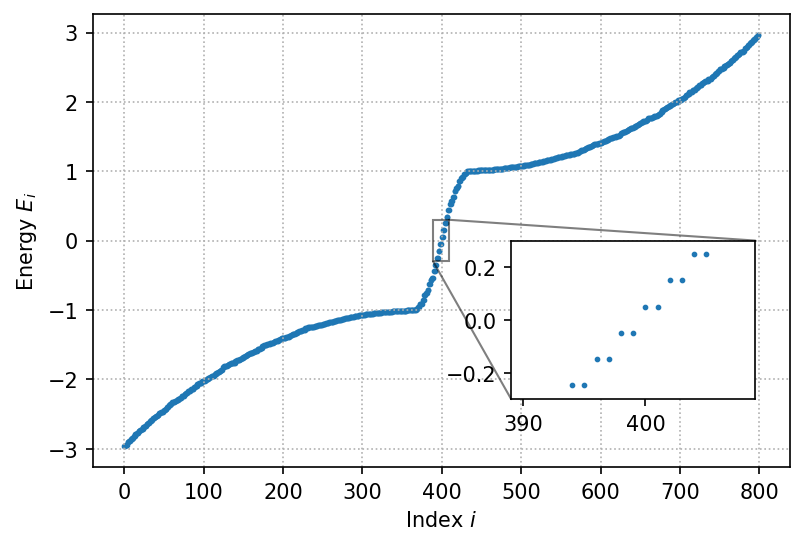

In [58]:
mu = 2.0
delta = complex(1.0, 0.0)
t = 1

n = -1
hop_phase_triangle = np.exp(n * np.pi * 1j / 2)
hop_phase_pentagon = hop_phase_triangle.conjugate()
flagged_bonds_triangle = [
    (
        N_hole * N + N_hole + 2 * N_hole * i,
        N_hole * N + N_hole * (2 * N_hole) + N_hole + i,
    )
    for i in range(N_hole)
]
flagged_bonds_pentagon = []
print("flagged_bonds_triangle = ", flagged_bonds_triangle)

# flagged_bonds_pentagon = [(34, 27), (35, 28), (36, 29)]
# flagged_bonds_pentagon = [(27, 47), (17, 40), (7, 33), (24, 23), (14, 13), (4, 3)]

# flagged_bonds_pentagon = [(27, 47), (17, 40), (7, 33), (24, 23), (14, 13), (4, 3), (57, 48), (56, 41), (55, 34)]

Ham_constructor = HamiltonianConstructor(mu - 4 * t, t, t, delta)
H_direct_lattice = Ham_constructor.construct_direct_lattice_hamiltonian(lattice)
block_indices = Ham_constructor.get_block_indices(lattice.get_num_sites())

for flagged_bond in flagged_bonds_triangle:
    Ham_constructor.add_phase(
        H_direct_lattice, flagged_bond, hop_phase_triangle, num_sites
    )

for flagged_bond in flagged_bonds_pentagon:
    Ham_constructor.add_phase(
        H_direct_lattice, flagged_bond, hop_phase_pentagon, num_sites
    )

energies, states = scipy.linalg.eigh(H_direct_lattice)

tol = 0.05
low_energy_indices = np.argwhere(np.abs(energies) < tol)[:, 0]
print(low_energy_indices)

print("Lowest found energy: ", np.min(np.abs(energies)))
gs_idx = np.argmin(np.abs(energies))
print("Index of lowest absolute energy: ", gs_idx)

fig, ax = plt.subplots()
plt.xlabel(r"Index $i$")
plt.ylabel(r"Energy $E_{i}$")
plt.grid(linestyle=":", zorder=100)
# plt.title("Energy Eigenvalues of Chiral p-wave SC")
ax.scatter(range(len(energies)), energies, s=3)

axins = ax.inset_axes([0.6, 0.15, 0.35, 0.35])
axins.scatter(range(len(energies)), energies, s=3, zorder=-100)
x1, x2, y1, y2 = gs_idx - 10, gs_idx + 10, -0.3, 0.3
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.savefig(f"./plots/discl_dipole_spectrum_n_{n}.svg")

plt.show()

idx = 399 with energy -0.04988369393592851


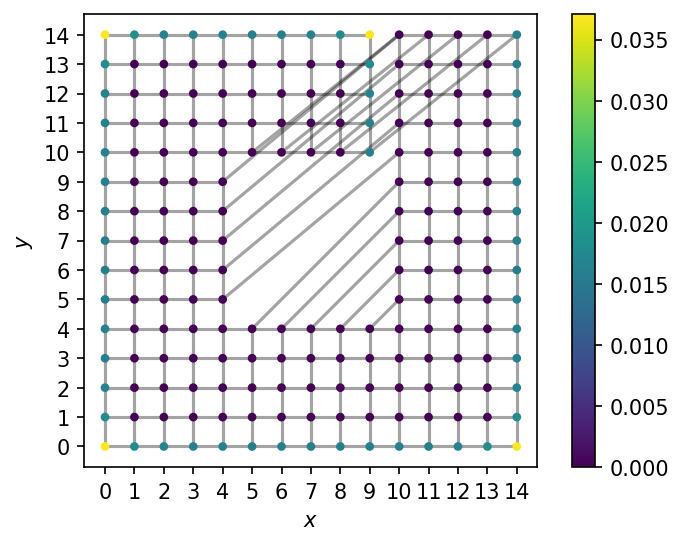

In [59]:
for gs_idx in range(gs_idx, gs_idx + 1):
    print(f"idx = {gs_idx} with energy {energies[gs_idx]}")
    gs_wave_function = states[:, gs_idx]
    gs_probabilities_nambu = np.square(np.abs(gs_wave_function))
    gs_probabilities = np.zeros(shape=(num_sites, 1))

    for site_idx in range(num_sites):
        gs_probabilities[site_idx] = np.sum(
            gs_probabilities_nambu[block_indices[site_idx]]
        )

    x_values = [k[0] for k in lattice_sites]
    y_values = [k[1] for k in lattice_sites]

    color_map = plt.get_cmap("viridis")
    sc = lattice.plot(False, c=(gs_probabilities), cmap=color_map)
    plt.colorbar(sc)

    plt.savefig(f"./plots/discl_dipole_prob_distr_n_{n}.svg")
    plt.show()